# Wandb

In [259]:
!pip install wandb

In [260]:
!wandb login

wandb: Currently logged in as: pathekarpranav05 (pranav4175). Use `wandb login --relogin` to force relogin


In [261]:
import wandb
import keras

In [262]:
pip install wandb-callbacks

In [263]:
wandb.init(project="proper", entity="pranav4175")

accuracy,▁▁▃▅▇▇██████████████████████████████████
auc_6,██▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
binary_accuracy,▁▁▃▅▇▇██████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
mean_iou,▆▆▇▇██▇▆▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision_6,▁▁▂▂▃▄▄▅▅▆▆▆▇▇▇▇▇█▇██▇████▇███▇██████▇▇█
recall_6,███▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▇████████████████████████████████████
val_auc_6,█████▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄
val_binary_accuracy,▁▂▅▇████████████████████████████████████


# ***Getting things ready***

In [264]:
!pip install imagecodecs
# Restart the kernel
import os
#os.kill(os.getpid(), 9)

In [265]:
import os
import random
import imagecodecs
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tifffile as tiff
import matplotlib.pyplot as plt
from keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy

In [266]:
seed = 42
np.random.seed = seed

In [267]:
IMG_WIDTH=512
IMG_HEIGHT=512
IMG_CHANNELS=3

In [268]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [269]:
X_train = np.zeros((16+16, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((16+16, IMG_HEIGHT, IMG_WIDTH), dtype=np.bool_)
print(X_train.shape, Y_train.shape)

(32, 512, 512, 3) (32, 512, 512)


# X_train & Y_train

In [270]:
import os
TRAIN_PATH = "/content/drive/MyDrive/BuildingModel/SatelliteDataPatches"
print(next(os.walk(TRAIN_PATH))[0])
print(next(os.walk(TRAIN_PATH))[1])
print(next(os.walk(TRAIN_PATH))[2])

/content/drive/MyDrive/BuildingModel/SatelliteDataPatches
['Hyde_1_Clipped_image_patches', 'Hyde_1_Clipped_mask_patches', 'Hyde_2_Clipped_image_patches', 'Hyde_2_Clipped_mask_patches']
[]


In [271]:
X_trainFolders = []
Y_trainFolders = []
TrainFolders = next(os.walk(TRAIN_PATH))[1]
for i in TrainFolders:
  if(i.endswith('image_patches') and i.startswith('Hyd')):
    X_trainFolders.append(i)
  elif(i.endswith('mask_patches') and i.startswith('Hyd')):
    Y_trainFolders.append(i)
print(X_trainFolders,Y_trainFolders)

['Hyde_1_Clipped_image_patches', 'Hyde_2_Clipped_image_patches'] ['Hyde_1_Clipped_mask_patches', 'Hyde_2_Clipped_mask_patches']


In [272]:
import re

x = 0
y = 0

for image_folder, mask_folder in zip(X_trainFolders, Y_trainFolders):
    image_files = sorted(next(os.walk(f'{TRAIN_PATH}/{image_folder}'))[2], key=lambda x: int(re.search(r'\d+', x).group()))
    mask_files = sorted([f[:-4] + '_mask.tif' for f in image_files], key=lambda x: int(re.search(r'\d+', x[:-14]).group()))

    for image_file, mask_file in zip(image_files, mask_files):
        print(f'Loading image: {image_file}')

        ximg = tiff.imread(f'{TRAIN_PATH}/{image_folder}/{image_file}')
        X_train[x] = ximg
        x += 1

        print(f'Loading mask: {mask_file}')
        ymas = tiff.imread(f'{TRAIN_PATH}/{mask_folder}/{mask_file}')
        Y_train[y] = ymas
        y += 1

Loading image: Hyde_1_patch_14.tif
Loading mask: Hyde_1_patch_14_mask.tif
Loading image: Hyde_1_patch_6.tif
Loading mask: Hyde_1_patch_6_mask.tif
Loading image: Hyde_1_patch_10.tif
Loading mask: Hyde_1_patch_10_mask.tif
Loading image: Hyde_1_patch_1.tif
Loading mask: Hyde_1_patch_1_mask.tif
Loading image: Hyde_1_patch_0.tif
Loading mask: Hyde_1_patch_0_mask.tif
Loading image: Hyde_1_patch_15.tif
Loading mask: Hyde_1_patch_15_mask.tif
Loading image: Hyde_1_patch_11.tif
Loading mask: Hyde_1_patch_11_mask.tif
Loading image: Hyde_1_patch_5.tif
Loading mask: Hyde_1_patch_5_mask.tif
Loading image: Hyde_1_patch_13.tif
Loading mask: Hyde_1_patch_13_mask.tif
Loading image: Hyde_1_patch_3.tif
Loading mask: Hyde_1_patch_3_mask.tif
Loading image: Hyde_1_patch_12.tif
Loading mask: Hyde_1_patch_12_mask.tif
Loading image: Hyde_1_patch_2.tif
Loading mask: Hyde_1_patch_2_mask.tif
Loading image: Hyde_1_patch_4.tif
Loading mask: Hyde_1_patch_4_mask.tif
Loading image: Hyde_1_patch_9.tif
Loading mask: Hyde

In [273]:
print(X_train.shape,Y_train.shape,x,y)

(32, 512, 512, 3) (32, 512, 512) 32 32


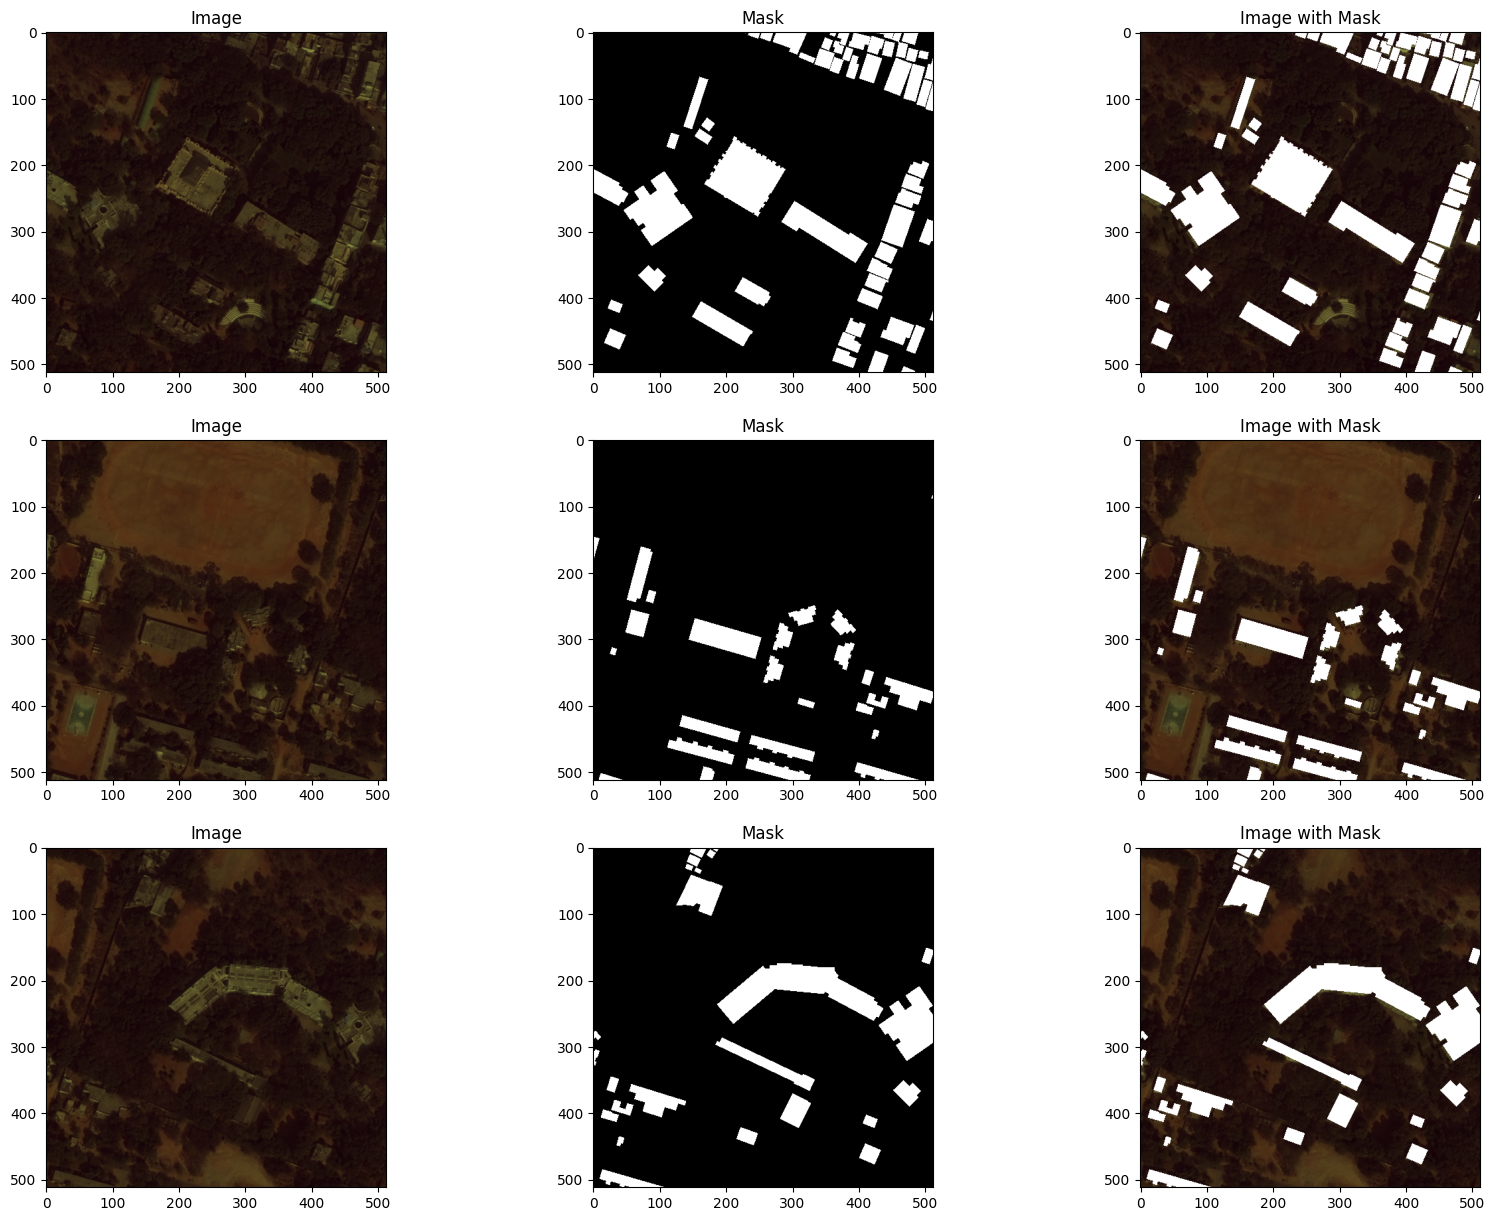

In [274]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig, axs = plt.subplots(3, 3, figsize=(20, 15))

for count in range(3):
    img = X_train[count]
    axs[count][0].set_title("Image")
    axs[count][0].imshow(img)

    mask = Y_train[count]
    axs[count][1].set_title("Mask")
    axs[count][1].imshow(mask, cmap='gray')


    mask = mask.astype(np.uint8)

    img_with_mask = np.copy(img)

    img_with_mask[mask == 1] = 255
    axs[count][2].set_title("Image with Mask")
    axs[count][2].imshow(img_with_mask)

plt.show()


# ***Model***

***Model***

In [275]:
#Build the model

# Define input layer
input = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# Normalize input data
s = tf.keras.layers.Lambda(lambda x: x / 255)(input)

In [276]:
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convert probabilities to binary values
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

In [277]:


tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_focal_crossentropy'
)


In [278]:
import tensorflow as tf

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)


model = tf.keras.Model(inputs=input, outputs=outputs)

model.compile(optimizer='SGD', loss='binary_focal_crossentropy', metrics=['accuracy', mean_iou, BinaryAccuracy(),
    Precision(),
    Recall(),
    AUC()])


'''
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
    BinaryAccuracy(),
    FalsePositives(),
    FalseNegatives(),
    TruePositives(),
    TrueNegatives(),
    Precision(),
    Recall(),
    AUC()
])
'''
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 lambda_9 (Lambda)           (None, 512, 512, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv2d_133 (Conv2D)         (None, 512, 512, 16)         448       ['lambda_9[0][0]']            
                                                                                                  
 dropout_63 (Dropout)        (None, 512, 512, 16)         0         ['conv2d_133[0][0]']          
                                                                                            

# ***Training***

In [281]:
import matplotlib.pyplot as plt

def plot_accu_vs_loss(results):
  # Create a figure and subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Plot training accuracy and loss
  axs[0].plot(results.history['accuracy'], label='Training Accuracy')
  axs[0].plot(results.history['val_accuracy'], label='Validation Accuracy')
  axs[0].set_title('Training Metrics')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Value')
  axs[0].legend()
  # axs[0].set_xlim(0, 100)

  # Plot validation accuracy and loss
  axs[1].plot(results.history['loss'], label='Training loss')
  axs[1].plot(results.history['val_loss'], label='Validation Loss')
  axs[1].set_title('Validation Metrics')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Value')
  axs[1].legend()
  # axs[1].set_xlim(0, 100)


  # Adjust layout
  plt.tight_layout()
  plt.show()


In [282]:
import matplotlib.pyplot as plt

def plot_train_vs_val(results):
  # Create a figure and subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Plot training accuracy and loss
  axs[0].plot(results.history['accuracy'], label='Training Accuracy')
  axs[0].plot(results.history['loss'], label='Training Loss')
  axs[0].set_title('Training Metrics')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Value')
  axs[0].legend()
  # axs[0].set_xlim(0, 100)

  # Plot validation accuracy and loss
  axs[1].plot(results.history['val_accuracy'], label='Validation Accuracy')
  axs[1].plot(results.history['val_loss'], label='Validation Loss')
  axs[1].set_title('Validation Metrics')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Value')
  axs[1].legend()
  # axs[1].set_xlim(0, 100)


  # Adjust layout
  plt.tight_layout()
  plt.show()


***Training***

In [283]:
################################
import wandb
import keras
from wandb.keras import WandbCallback

# ModelCheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Satellite_model_on_hyde150.h5', verbose=1
)

callbacks = [WandbCallback(), checkpointer]
# tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
# tf.keras.callbacks.TensorBoard(log_dir='logs')

####################################

In [ ]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, steps_per_epoch=len(X_train)//16, shuffle=False,callbacks=callbacks, verbose=1)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.3628 - mean_iou: 0.2331 - binary_accuracy: 0.3628 - precision_7: 0.2511 - recall_7: 0.7897 - auc_7: 0.5689

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 1: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 11s 7s/step - loss: 0.1936 - accuracy: 0.3628 - mean_iou: 0.2331 - binary_accuracy: 0.3628 - precision_7: 0.2511 - recall_7: 0.7897 - auc_7: 0.5689 - val_loss: 0.1764 - val_accuracy: 0.4029 - val_mean_iou: 0.1733 - val_binary_accuracy: 0.4029 - val_precision_7: 0.1814 - val_recall_7: 0.7959 - val_auc_7: 0.6811
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.4286 - mean_iou: 0.2256 - binary_accuracy: 0.4286 - precision_7: 0.2554 - recall_7: 0.6788 - auc_7: 0.5486

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 2: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1850 - accuracy: 0.4286 - mean_iou: 0.2256 - binary_accuracy: 0.4286 - precision_7: 0.2554 - recall_7: 0.6788 - auc_7: 0.5486 - val_loss: 0.1679 - val_accuracy: 0.7248 - val_mean_iou: 0.2167 - val_binary_accuracy: 0.7248 - val_precision_7: 0.2818 - val_recall_7: 0.4838 - val_auc_7: 0.6090
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.4938 - mean_iou: 0.2158 - binary_accuracy: 0.4938 - precision_7: 0.2612 - recall_7: 0.5676 - auc_7: 0.5304

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 3: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 9s 8s/step - loss: 0.1788 - accuracy: 0.4938 - mean_iou: 0.2158 - binary_accuracy: 0.4938 - precision_7: 0.2612 - recall_7: 0.5676 - auc_7: 0.5304 - val_loss: 0.1616 - val_accuracy: 0.8291 - val_mean_iou: 0.1663 - val_binary_accuracy: 0.8291 - val_precision_7: 0.4170 - val_recall_7: 0.2167 - val_auc_7: 0.5354
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.5510 - mean_iou: 0.2035 - binary_accuracy: 0.5510 - precision_7: 0.2682 - recall_7: 0.4671 - auc_7: 0.5147

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 4: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1742 - accuracy: 0.5510 - mean_iou: 0.2035 - binary_accuracy: 0.5510 - precision_7: 0.2682 - recall_7: 0.4671 - auc_7: 0.5147 - val_loss: 0.1569 - val_accuracy: 0.8409 - val_mean_iou: 0.0815 - val_binary_accuracy: 0.8409 - val_precision_7: 0.4705 - val_recall_7: 0.0898 - val_auc_7: 0.4690
Epoch 5/100
2/2 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.5969 - mean_iou: 0.1885 - binary_accuracy: 0.5969 - precision_7: 0.2752 - recall_7: 0.3811 - auc_7: 0.5003

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 5: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1708 - accuracy: 0.5969 - mean_iou: 0.1885 - binary_accuracy: 0.5969 - precision_7: 0.2752 - recall_7: 0.3811 - auc_7: 0.5003 - val_loss: 0.1534 - val_accuracy: 0.8418 - val_mean_iou: 0.0372 - val_binary_accuracy: 0.8418 - val_precision_7: 0.4651 - val_recall_7: 0.0389 - val_auc_7: 0.4148
Epoch 6/100
2/2 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.6326 - mean_iou: 0.1722 - binary_accuracy: 0.6326 - precision_7: 0.2823 - recall_7: 0.3105 - auc_7: 0.4882

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 6: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1681 - accuracy: 0.6326 - mean_iou: 0.1722 - binary_accuracy: 0.6326 - precision_7: 0.2823 - recall_7: 0.3105 - auc_7: 0.4882 - val_loss: 0.1507 - val_accuracy: 0.8417 - val_mean_iou: 0.0174 - val_binary_accuracy: 0.8417 - val_precision_7: 0.4238 - val_recall_7: 0.0178 - val_auc_7: 0.3732
Epoch 7/100
2/2 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.6594 - mean_iou: 0.1553 - binary_accuracy: 0.6594 - precision_7: 0.2890 - recall_7: 0.2543 - auc_7: 0.4771

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 7: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1660 - accuracy: 0.6594 - mean_iou: 0.1553 - binary_accuracy: 0.6594 - precision_7: 0.2890 - recall_7: 0.2543 - auc_7: 0.4771 - val_loss: 0.1487 - val_accuracy: 0.8417 - val_mean_iou: 0.0086 - val_binary_accuracy: 0.8417 - val_precision_7: 0.3682 - val_recall_7: 0.0087 - val_auc_7: 0.3418
Epoch 8/100
2/2 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.6801 - mean_iou: 0.1393 - binary_accuracy: 0.6801 - precision_7: 0.2965 - recall_7: 0.2098 - auc_7: 0.4688

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 8: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1643 - accuracy: 0.6801 - mean_iou: 0.1393 - binary_accuracy: 0.6801 - precision_7: 0.2965 - recall_7: 0.2098 - auc_7: 0.4688 - val_loss: 0.1470 - val_accuracy: 0.8419 - val_mean_iou: 0.0050 - val_binary_accuracy: 0.8419 - val_precision_7: 0.3295 - val_recall_7: 0.0050 - val_auc_7: 0.3184
Epoch 9/100
2/2 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.6949 - mean_iou: 0.1236 - binary_accuracy: 0.6949 - precision_7: 0.3022 - recall_7: 0.1741 - auc_7: 0.4603

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 9: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 8s 7s/step - loss: 0.1629 - accuracy: 0.6949 - mean_iou: 0.1236 - binary_accuracy: 0.6949 - precision_7: 0.3022 - recall_7: 0.1741 - auc_7: 0.4603 - val_loss: 0.1458 - val_accuracy: 0.8420 - val_mean_iou: 0.0034 - val_binary_accuracy: 0.8420 - val_precision_7: 0.3104 - val_recall_7: 0.0034 - val_auc_7: 0.3003
Epoch 10/100
2/2 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.7061 - mean_iou: 0.1094 - binary_accuracy: 0.7061 - precision_7: 0.3073 - recall_7: 0.1459 - auc_7: 0.4532

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 10: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1618 - accuracy: 0.7061 - mean_iou: 0.1094 - binary_accuracy: 0.7061 - precision_7: 0.3073 - recall_7: 0.1459 - auc_7: 0.4532 - val_loss: 0.1447 - val_accuracy: 0.8422 - val_mean_iou: 0.0025 - val_binary_accuracy: 0.8422 - val_precision_7: 0.2996 - val_recall_7: 0.0025 - val_auc_7: 0.2866
Epoch 11/100
2/2 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.7152 - mean_iou: 0.0976 - binary_accuracy: 0.7152 - precision_7: 0.3146 - recall_7: 0.1243 - auc_7: 0.4477

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 11: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1608 - accuracy: 0.7152 - mean_iou: 0.0976 - binary_accuracy: 0.7152 - precision_7: 0.3146 - recall_7: 0.1243 - auc_7: 0.4477 - val_loss: 0.1438 - val_accuracy: 0.8423 - val_mean_iou: 0.0020 - val_binary_accuracy: 0.8423 - val_precision_7: 0.3000 - val_recall_7: 0.0020 - val_auc_7: 0.2759
Epoch 12/100
2/2 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.7219 - mean_iou: 0.0863 - binary_accuracy: 0.7219 - precision_7: 0.3199 - recall_7: 0.1060 - auc_7: 0.4425

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 12: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 6s/step - loss: 0.1600 - accuracy: 0.7219 - mean_iou: 0.0863 - binary_accuracy: 0.7219 - precision_7: 0.3199 - recall_7: 0.1060 - auc_7: 0.4425 - val_loss: 0.1430 - val_accuracy: 0.8424 - val_mean_iou: 0.0017 - val_binary_accuracy: 0.8424 - val_precision_7: 0.3050 - val_recall_7: 0.0017 - val_auc_7: 0.2674
Epoch 13/100
2/2 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.7270 - mean_iou: 0.0771 - binary_accuracy: 0.7270 - precision_7: 0.3251 - recall_7: 0.0919 - auc_7: 0.4380

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 13: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1594 - accuracy: 0.7270 - mean_iou: 0.0771 - binary_accuracy: 0.7270 - precision_7: 0.3251 - recall_7: 0.0919 - auc_7: 0.4380 - val_loss: 0.1423 - val_accuracy: 0.8424 - val_mean_iou: 0.0014 - val_binary_accuracy: 0.8424 - val_precision_7: 0.3008 - val_recall_7: 0.0014 - val_auc_7: 0.2605
Epoch 14/100
2/2 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.7310 - mean_iou: 0.0686 - binary_accuracy: 0.7310 - precision_7: 0.3289 - recall_7: 0.0797 - auc_7: 0.4341

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 14: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1588 - accuracy: 0.7310 - mean_iou: 0.0686 - binary_accuracy: 0.7310 - precision_7: 0.3289 - recall_7: 0.0797 - auc_7: 0.4341 - val_loss: 0.1417 - val_accuracy: 0.8424 - val_mean_iou: 0.0013 - val_binary_accuracy: 0.8424 - val_precision_7: 0.3107 - val_recall_7: 0.0013 - val_auc_7: 0.2550
Epoch 15/100
2/2 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.7341 - mean_iou: 0.0617 - binary_accuracy: 0.7341 - precision_7: 0.3333 - recall_7: 0.0704 - auc_7: 0.4306

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 15: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1583 - accuracy: 0.7341 - mean_iou: 0.0617 - binary_accuracy: 0.7341 - precision_7: 0.3333 - recall_7: 0.0704 - auc_7: 0.4306 - val_loss: 0.1411 - val_accuracy: 0.8425 - val_mean_iou: 0.0012 - val_binary_accuracy: 0.8425 - val_precision_7: 0.3083 - val_recall_7: 0.0012 - val_auc_7: 0.2506
Epoch 16/100
2/2 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.7367 - mean_iou: 0.0557 - binary_accuracy: 0.7367 - precision_7: 0.3376 - recall_7: 0.0625 - auc_7: 0.4277

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 16: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1578 - accuracy: 0.7367 - mean_iou: 0.0557 - binary_accuracy: 0.7367 - precision_7: 0.3376 - recall_7: 0.0625 - auc_7: 0.4277 - val_loss: 0.1406 - val_accuracy: 0.8425 - val_mean_iou: 0.0011 - val_binary_accuracy: 0.8425 - val_precision_7: 0.3027 - val_recall_7: 0.0011 - val_auc_7: 0.2468
Epoch 17/100
2/2 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.7388 - mean_iou: 0.0505 - binary_accuracy: 0.7388 - precision_7: 0.3420 - recall_7: 0.0558 - auc_7: 0.4254

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 17: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1574 - accuracy: 0.7388 - mean_iou: 0.0505 - binary_accuracy: 0.7388 - precision_7: 0.3420 - recall_7: 0.0558 - auc_7: 0.4254 - val_loss: 0.1401 - val_accuracy: 0.8425 - val_mean_iou: 0.0010 - val_binary_accuracy: 0.8425 - val_precision_7: 0.3064 - val_recall_7: 0.0010 - val_auc_7: 0.2439
Epoch 18/100
2/2 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.7404 - mean_iou: 0.0463 - binary_accuracy: 0.7404 - precision_7: 0.3457 - recall_7: 0.0506 - auc_7: 0.4233

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 18: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1571 - accuracy: 0.7404 - mean_iou: 0.0463 - binary_accuracy: 0.7404 - precision_7: 0.3457 - recall_7: 0.0506 - auc_7: 0.4233 - val_loss: 0.1397 - val_accuracy: 0.8425 - val_mean_iou: 9.7400e-04 - val_binary_accuracy: 0.8425 - val_precision_7: 0.3145 - val_recall_7: 9.7608e-04 - val_auc_7: 0.2413
Epoch 19/100
2/2 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.7419 - mean_iou: 0.0428 - binary_accuracy: 0.7419 - precision_7: 0.3514 - recall_7: 0.0463 - auc_7: 0.4214

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 19: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1567 - accuracy: 0.7419 - mean_iou: 0.0428 - binary_accuracy: 0.7419 - precision_7: 0.3514 - recall_7: 0.0463 - auc_7: 0.4214 - val_loss: 0.1393 - val_accuracy: 0.8425 - val_mean_iou: 9.4388e-04 - val_binary_accuracy: 0.8425 - val_precision_7: 0.3210 - val_recall_7: 9.4576e-04 - val_auc_7: 0.2395
Epoch 20/100
2/2 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.7429 - mean_iou: 0.0392 - binary_accuracy: 0.7429 - precision_7: 0.3529 - recall_7: 0.0421 - auc_7: 0.4201

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 20: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1565 - accuracy: 0.7429 - mean_iou: 0.0392 - binary_accuracy: 0.7429 - precision_7: 0.3529 - recall_7: 0.0421 - auc_7: 0.4201 - val_loss: 0.1389 - val_accuracy: 0.8426 - val_mean_iou: 9.2590e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3385 - val_recall_7: 9.2758e-04 - val_auc_7: 0.2377
Epoch 21/100
2/2 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.7437 - mean_iou: 0.0362 - binary_accuracy: 0.7437 - precision_7: 0.3548 - recall_7: 0.0386 - auc_7: 0.4183

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 21: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1562 - accuracy: 0.7437 - mean_iou: 0.0362 - binary_accuracy: 0.7437 - precision_7: 0.3548 - recall_7: 0.0386 - auc_7: 0.4183 - val_loss: 0.1386 - val_accuracy: 0.8426 - val_mean_iou: 8.8366e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3460 - val_recall_7: 8.8514e-04 - val_auc_7: 0.2363
Epoch 22/100
2/2 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.7448 - mean_iou: 0.0342 - binary_accuracy: 0.7448 - precision_7: 0.3626 - recall_7: 0.0362 - auc_7: 0.4170

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 22: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1560 - accuracy: 0.7448 - mean_iou: 0.0342 - binary_accuracy: 0.7448 - precision_7: 0.3626 - recall_7: 0.0362 - auc_7: 0.4170 - val_loss: 0.1382 - val_accuracy: 0.8426 - val_mean_iou: 8.5351e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3561 - val_recall_7: 8.5483e-04 - val_auc_7: 0.2351
Epoch 23/100
2/2 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.7452 - mean_iou: 0.0318 - binary_accuracy: 0.7452 - precision_7: 0.3621 - recall_7: 0.0335 - auc_7: 0.4170

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 23: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1557 - accuracy: 0.7452 - mean_iou: 0.0318 - binary_accuracy: 0.7452 - precision_7: 0.3621 - recall_7: 0.0335 - auc_7: 0.4170 - val_loss: 0.1379 - val_accuracy: 0.8426 - val_mean_iou: 8.2936e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3615 - val_recall_7: 8.3057e-04 - val_auc_7: 0.2343
Epoch 24/100
2/2 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.7459 - mean_iou: 0.0301 - binary_accuracy: 0.7459 - precision_7: 0.3670 - recall_7: 0.0315 - auc_7: 0.4156

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 24: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1555 - accuracy: 0.7459 - mean_iou: 0.0301 - binary_accuracy: 0.7459 - precision_7: 0.3670 - recall_7: 0.0315 - auc_7: 0.4156 - val_loss: 0.1376 - val_accuracy: 0.8426 - val_mean_iou: 8.1130e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3764 - val_recall_7: 8.1239e-04 - val_auc_7: 0.2338
Epoch 25/100
2/2 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.7464 - mean_iou: 0.0286 - binary_accuracy: 0.7464 - precision_7: 0.3713 - recall_7: 0.0299 - auc_7: 0.4153

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 25: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1553 - accuracy: 0.7464 - mean_iou: 0.0286 - binary_accuracy: 0.7464 - precision_7: 0.3713 - recall_7: 0.0299 - auc_7: 0.4153 - val_loss: 0.1373 - val_accuracy: 0.8426 - val_mean_iou: 7.6897e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3769 - val_recall_7: 7.6995e-04 - val_auc_7: 0.2334
Epoch 26/100
2/2 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.7468 - mean_iou: 0.0272 - binary_accuracy: 0.7468 - precision_7: 0.3736 - recall_7: 0.0282 - auc_7: 0.4148

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 26: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1552 - accuracy: 0.7468 - mean_iou: 0.0272 - binary_accuracy: 0.7468 - precision_7: 0.3736 - recall_7: 0.0282 - auc_7: 0.4148 - val_loss: 0.1371 - val_accuracy: 0.8426 - val_mean_iou: 7.5689e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3811 - val_recall_7: 7.5782e-04 - val_auc_7: 0.2329
Epoch 27/100
2/2 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.7472 - mean_iou: 0.0259 - binary_accuracy: 0.7472 - precision_7: 0.3761 - recall_7: 0.0268 - auc_7: 0.4140

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 27: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1550 - accuracy: 0.7472 - mean_iou: 0.0259 - binary_accuracy: 0.7472 - precision_7: 0.3761 - recall_7: 0.0268 - auc_7: 0.4140 - val_loss: 0.1368 - val_accuracy: 0.8426 - val_mean_iou: 7.2666e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3822 - val_recall_7: 7.2751e-04 - val_auc_7: 0.2326
Epoch 28/100
2/2 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.7474 - mean_iou: 0.0245 - binary_accuracy: 0.7474 - precision_7: 0.3757 - recall_7: 0.0253 - auc_7: 0.4138

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 28: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1549 - accuracy: 0.7474 - mean_iou: 0.0245 - binary_accuracy: 0.7474 - precision_7: 0.3757 - recall_7: 0.0253 - auc_7: 0.4138 - val_loss: 0.1365 - val_accuracy: 0.8426 - val_mean_iou: 6.6007e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3670 - val_recall_7: 6.6082e-04 - val_auc_7: 0.2326
Epoch 29/100
2/2 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.7477 - mean_iou: 0.0236 - binary_accuracy: 0.7477 - precision_7: 0.3786 - recall_7: 0.0243 - auc_7: 0.4141

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 29: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1547 - accuracy: 0.7477 - mean_iou: 0.0236 - binary_accuracy: 0.7477 - precision_7: 0.3786 - recall_7: 0.0243 - auc_7: 0.4141 - val_loss: 0.1363 - val_accuracy: 0.8426 - val_mean_iou: 6.4194e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3719 - val_recall_7: 6.4263e-04 - val_auc_7: 0.2327
Epoch 30/100
2/2 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.7480 - mean_iou: 0.0228 - binary_accuracy: 0.7480 - precision_7: 0.3816 - recall_7: 0.0235 - auc_7: 0.4136

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 30: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1546 - accuracy: 0.7480 - mean_iou: 0.0228 - binary_accuracy: 0.7480 - precision_7: 0.3816 - recall_7: 0.0235 - auc_7: 0.4136 - val_loss: 0.1361 - val_accuracy: 0.8426 - val_mean_iou: 6.3591e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3791 - val_recall_7: 6.3657e-04 - val_auc_7: 0.2329
Epoch 31/100
2/2 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.7482 - mean_iou: 0.0220 - binary_accuracy: 0.7482 - precision_7: 0.3845 - recall_7: 0.0226 - auc_7: 0.4141

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 31: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1544 - accuracy: 0.7482 - mean_iou: 0.0220 - binary_accuracy: 0.7482 - precision_7: 0.3845 - recall_7: 0.0226 - auc_7: 0.4141 - val_loss: 0.1358 - val_accuracy: 0.8426 - val_mean_iou: 6.1170e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3769 - val_recall_7: 6.1232e-04 - val_auc_7: 0.2332
Epoch 32/100
2/2 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.7484 - mean_iou: 0.0212 - binary_accuracy: 0.7484 - precision_7: 0.3862 - recall_7: 0.0218 - auc_7: 0.4146

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 32: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1543 - accuracy: 0.7484 - mean_iou: 0.0212 - binary_accuracy: 0.7484 - precision_7: 0.3862 - recall_7: 0.0218 - auc_7: 0.4146 - val_loss: 0.1356 - val_accuracy: 0.8426 - val_mean_iou: 6.0567e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3831 - val_recall_7: 6.0626e-04 - val_auc_7: 0.2338
Epoch 33/100
2/2 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.7486 - mean_iou: 0.0206 - binary_accuracy: 0.7486 - precision_7: 0.3890 - recall_7: 0.0211 - auc_7: 0.4142

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 33: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1542 - accuracy: 0.7486 - mean_iou: 0.0206 - binary_accuracy: 0.7486 - precision_7: 0.3890 - recall_7: 0.0211 - auc_7: 0.4142 - val_loss: 0.1354 - val_accuracy: 0.8426 - val_mean_iou: 5.8753e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3911 - val_recall_7: 5.8807e-04 - val_auc_7: 0.2342
Epoch 34/100
2/2 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.7488 - mean_iou: 0.0203 - binary_accuracy: 0.7488 - precision_7: 0.3936 - recall_7: 0.0208 - auc_7: 0.4151

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 34: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1540 - accuracy: 0.7488 - mean_iou: 0.0203 - binary_accuracy: 0.7488 - precision_7: 0.3936 - recall_7: 0.0208 - auc_7: 0.4151 - val_loss: 0.1352 - val_accuracy: 0.8426 - val_mean_iou: 5.7544e-04 - val_binary_accuracy: 0.8426 - val_precision_7: 0.3958 - val_recall_7: 5.7595e-04 - val_auc_7: 0.2347
Epoch 35/100
2/2 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.7491 - mean_iou: 0.0200 - binary_accuracy: 0.7491 - precision_7: 0.4002 - recall_7: 0.0204 - auc_7: 0.4160

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 35: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1538 - accuracy: 0.7491 - mean_iou: 0.0200 - binary_accuracy: 0.7491 - precision_7: 0.4002 - recall_7: 0.0204 - auc_7: 0.4160 - val_loss: 0.1350 - val_accuracy: 0.8427 - val_mean_iou: 5.6940e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4034 - val_recall_7: 5.6988e-04 - val_auc_7: 0.2355
Epoch 36/100
2/2 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.7490 - mean_iou: 0.0193 - binary_accuracy: 0.7490 - precision_7: 0.3965 - recall_7: 0.0197 - auc_7: 0.4159

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 36: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 7s/step - loss: 0.1538 - accuracy: 0.7490 - mean_iou: 0.0193 - binary_accuracy: 0.7490 - precision_7: 0.3965 - recall_7: 0.0197 - auc_7: 0.4159 - val_loss: 0.1348 - val_accuracy: 0.8427 - val_mean_iou: 5.5125e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4044 - val_recall_7: 5.5170e-04 - val_auc_7: 0.2363
Epoch 37/100
2/2 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.7491 - mean_iou: 0.0190 - binary_accuracy: 0.7491 - precision_7: 0.3968 - recall_7: 0.0194 - auc_7: 0.4163

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 37: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1537 - accuracy: 0.7491 - mean_iou: 0.0190 - binary_accuracy: 0.7491 - precision_7: 0.3968 - recall_7: 0.0194 - auc_7: 0.4163 - val_loss: 0.1346 - val_accuracy: 0.8427 - val_mean_iou: 5.5126e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4136 - val_recall_7: 5.5170e-04 - val_auc_7: 0.2371
Epoch 38/100
2/2 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.7492 - mean_iou: 0.0186 - binary_accuracy: 0.7492 - precision_7: 0.3992 - recall_7: 0.0189 - auc_7: 0.4174

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 38: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 6s/step - loss: 0.1535 - accuracy: 0.7492 - mean_iou: 0.0186 - binary_accuracy: 0.7492 - precision_7: 0.3992 - recall_7: 0.0189 - auc_7: 0.4174 - val_loss: 0.1344 - val_accuracy: 0.8427 - val_mean_iou: 5.3917e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4178 - val_recall_7: 5.3957e-04 - val_auc_7: 0.2379
Epoch 39/100
2/2 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.7493 - mean_iou: 0.0185 - binary_accuracy: 0.7493 - precision_7: 0.4031 - recall_7: 0.0188 - auc_7: 0.4175

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 39: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1534 - accuracy: 0.7493 - mean_iou: 0.0185 - binary_accuracy: 0.7493 - precision_7: 0.4031 - recall_7: 0.0188 - auc_7: 0.4175 - val_loss: 0.1342 - val_accuracy: 0.8427 - val_mean_iou: 5.3312e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4211 - val_recall_7: 5.3351e-04 - val_auc_7: 0.2390
Epoch 40/100
2/2 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.7495 - mean_iou: 0.0182 - binary_accuracy: 0.7495 - precision_7: 0.4061 - recall_7: 0.0184 - auc_7: 0.4188

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 40: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1533 - accuracy: 0.7495 - mean_iou: 0.0182 - binary_accuracy: 0.7495 - precision_7: 0.4061 - recall_7: 0.0184 - auc_7: 0.4188 - val_loss: 0.1340 - val_accuracy: 0.8427 - val_mean_iou: 5.1496e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4229 - val_recall_7: 5.1532e-04 - val_auc_7: 0.2399
Epoch 41/100
2/2 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.7495 - mean_iou: 0.0179 - binary_accuracy: 0.7495 - precision_7: 0.4062 - recall_7: 0.0181 - auc_7: 0.4192

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 41: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 6s/step - loss: 0.1532 - accuracy: 0.7495 - mean_iou: 0.0179 - binary_accuracy: 0.7495 - precision_7: 0.4062 - recall_7: 0.0181 - auc_7: 0.4192 - val_loss: 0.1338 - val_accuracy: 0.8427 - val_mean_iou: 5.0891e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4264 - val_recall_7: 5.0926e-04 - val_auc_7: 0.2411
Epoch 42/100
2/2 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.7497 - mean_iou: 0.0178 - binary_accuracy: 0.7497 - precision_7: 0.4110 - recall_7: 0.0180 - auc_7: 0.4205

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 42: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1530 - accuracy: 0.7497 - mean_iou: 0.0178 - binary_accuracy: 0.7497 - precision_7: 0.4110 - recall_7: 0.0180 - auc_7: 0.4205 - val_loss: 0.1336 - val_accuracy: 0.8427 - val_mean_iou: 5.0286e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4323 - val_recall_7: 5.0319e-04 - val_auc_7: 0.2423
Epoch 43/100
2/2 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.7497 - mean_iou: 0.0176 - binary_accuracy: 0.7497 - precision_7: 0.4119 - recall_7: 0.0179 - auc_7: 0.4209

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 43: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1529 - accuracy: 0.7497 - mean_iou: 0.0176 - binary_accuracy: 0.7497 - precision_7: 0.4119 - recall_7: 0.0179 - auc_7: 0.4209 - val_loss: 0.1334 - val_accuracy: 0.8427 - val_mean_iou: 4.6652e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4231 - val_recall_7: 4.6682e-04 - val_auc_7: 0.2436
Epoch 44/100
2/2 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.7498 - mean_iou: 0.0173 - binary_accuracy: 0.7498 - precision_7: 0.4136 - recall_7: 0.0176 - auc_7: 0.4219

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 44: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1528 - accuracy: 0.7498 - mean_iou: 0.0173 - binary_accuracy: 0.7498 - precision_7: 0.4136 - recall_7: 0.0176 - auc_7: 0.4219 - val_loss: 0.1332 - val_accuracy: 0.8427 - val_mean_iou: 4.6653e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4278 - val_recall_7: 4.6682e-04 - val_auc_7: 0.2450
Epoch 45/100
2/2 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.7498 - mean_iou: 0.0172 - binary_accuracy: 0.7498 - precision_7: 0.4131 - recall_7: 0.0174 - auc_7: 0.4223

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 45: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1527 - accuracy: 0.7498 - mean_iou: 0.0172 - binary_accuracy: 0.7498 - precision_7: 0.4131 - recall_7: 0.0174 - auc_7: 0.4223 - val_loss: 0.1330 - val_accuracy: 0.8427 - val_mean_iou: 4.6048e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4318 - val_recall_7: 4.6076e-04 - val_auc_7: 0.2464
Epoch 46/100
2/2 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.7498 - mean_iou: 0.0170 - binary_accuracy: 0.7498 - precision_7: 0.4133 - recall_7: 0.0172 - auc_7: 0.4235

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 46: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1526 - accuracy: 0.7498 - mean_iou: 0.0170 - binary_accuracy: 0.7498 - precision_7: 0.4133 - recall_7: 0.0172 - auc_7: 0.4235 - val_loss: 0.1328 - val_accuracy: 0.8427 - val_mean_iou: 4.4836e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4277 - val_recall_7: 4.4863e-04 - val_auc_7: 0.2480
Epoch 47/100
2/2 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.7500 - mean_iou: 0.0171 - binary_accuracy: 0.7500 - precision_7: 0.4206 - recall_7: 0.0173 - auc_7: 0.4247

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 47: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 8s 7s/step - loss: 0.1525 - accuracy: 0.7500 - mean_iou: 0.0171 - binary_accuracy: 0.7500 - precision_7: 0.4206 - recall_7: 0.0173 - auc_7: 0.4247 - val_loss: 0.1326 - val_accuracy: 0.8427 - val_mean_iou: 4.4232e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4398 - val_recall_7: 4.4257e-04 - val_auc_7: 0.2496
Epoch 48/100
2/2 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.7499 - mean_iou: 0.0169 - binary_accuracy: 0.7499 - precision_7: 0.4181 - recall_7: 0.0171 - auc_7: 0.4256

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 48: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1524 - accuracy: 0.7499 - mean_iou: 0.0169 - binary_accuracy: 0.7499 - precision_7: 0.4181 - recall_7: 0.0171 - auc_7: 0.4256 - val_loss: 0.1325 - val_accuracy: 0.8427 - val_mean_iou: 4.4233e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4451 - val_recall_7: 4.4257e-04 - val_auc_7: 0.2513
Epoch 49/100
2/2 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.7500 - mean_iou: 0.0172 - binary_accuracy: 0.7500 - precision_7: 0.4241 - recall_7: 0.0173 - auc_7: 0.4268

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 49: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1523 - accuracy: 0.7500 - mean_iou: 0.0172 - binary_accuracy: 0.7500 - precision_7: 0.4241 - recall_7: 0.0173 - auc_7: 0.4268 - val_loss: 0.1323 - val_accuracy: 0.8427 - val_mean_iou: 4.4235e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4679 - val_recall_7: 4.4257e-04 - val_auc_7: 0.2531
Epoch 50/100
2/2 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.7500 - mean_iou: 0.0171 - binary_accuracy: 0.7500 - precision_7: 0.4230 - recall_7: 0.0172 - auc_7: 0.4282

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 50: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1521 - accuracy: 0.7500 - mean_iou: 0.0171 - binary_accuracy: 0.7500 - precision_7: 0.4230 - recall_7: 0.0172 - auc_7: 0.4282 - val_loss: 0.1321 - val_accuracy: 0.8427 - val_mean_iou: 4.2417e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4605 - val_recall_7: 4.2438e-04 - val_auc_7: 0.2549
Epoch 51/100
2/2 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.7501 - mean_iou: 0.0170 - binary_accuracy: 0.7501 - precision_7: 0.4238 - recall_7: 0.0171 - auc_7: 0.4289

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 51: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1520 - accuracy: 0.7501 - mean_iou: 0.0170 - binary_accuracy: 0.7501 - precision_7: 0.4238 - recall_7: 0.0171 - auc_7: 0.4289 - val_loss: 0.1319 - val_accuracy: 0.8427 - val_mean_iou: 4.1812e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4631 - val_recall_7: 4.1832e-04 - val_auc_7: 0.2568
Epoch 52/100
2/2 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.7501 - mean_iou: 0.0170 - binary_accuracy: 0.7501 - precision_7: 0.4267 - recall_7: 0.0172 - auc_7: 0.4303

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 52: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1519 - accuracy: 0.7501 - mean_iou: 0.0170 - binary_accuracy: 0.7501 - precision_7: 0.4267 - recall_7: 0.0172 - auc_7: 0.4303 - val_loss: 0.1317 - val_accuracy: 0.8427 - val_mean_iou: 4.1207e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4722 - val_recall_7: 4.1226e-04 - val_auc_7: 0.2588
Epoch 53/100
2/2 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.7502 - mean_iou: 0.0170 - binary_accuracy: 0.7502 - precision_7: 0.4300 - recall_7: 0.0172 - auc_7: 0.4313

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 53: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1518 - accuracy: 0.7502 - mean_iou: 0.0170 - binary_accuracy: 0.7502 - precision_7: 0.4300 - recall_7: 0.0172 - auc_7: 0.4313 - val_loss: 0.1315 - val_accuracy: 0.8427 - val_mean_iou: 4.1207e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4823 - val_recall_7: 4.1226e-04 - val_auc_7: 0.2609
Epoch 54/100
2/2 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.7502 - mean_iou: 0.0171 - binary_accuracy: 0.7502 - precision_7: 0.4302 - recall_7: 0.0172 - auc_7: 0.4321

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 54: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1517 - accuracy: 0.7502 - mean_iou: 0.0171 - binary_accuracy: 0.7502 - precision_7: 0.4302 - recall_7: 0.0172 - auc_7: 0.4321 - val_loss: 0.1314 - val_accuracy: 0.8427 - val_mean_iou: 4.1814e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4894 - val_recall_7: 4.1832e-04 - val_auc_7: 0.2631
Epoch 55/100
2/2 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.7502 - mean_iou: 0.0169 - binary_accuracy: 0.7502 - precision_7: 0.4316 - recall_7: 0.0171 - auc_7: 0.4337

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 55: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1516 - accuracy: 0.7502 - mean_iou: 0.0169 - binary_accuracy: 0.7502 - precision_7: 0.4316 - recall_7: 0.0171 - auc_7: 0.4337 - val_loss: 0.1312 - val_accuracy: 0.8427 - val_mean_iou: 4.1208e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.4928 - val_recall_7: 4.1226e-04 - val_auc_7: 0.2653
Epoch 56/100
2/2 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.7503 - mean_iou: 0.0171 - binary_accuracy: 0.7503 - precision_7: 0.4323 - recall_7: 0.0172 - auc_7: 0.4351

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 56: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1515 - accuracy: 0.7503 - mean_iou: 0.0171 - binary_accuracy: 0.7503 - precision_7: 0.4323 - recall_7: 0.0172 - auc_7: 0.4351 - val_loss: 0.1310 - val_accuracy: 0.8427 - val_mean_iou: 4.0603e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5000 - val_recall_7: 4.0619e-04 - val_auc_7: 0.2677
Epoch 57/100
2/2 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.7503 - mean_iou: 0.0173 - binary_accuracy: 0.7503 - precision_7: 0.4365 - recall_7: 0.0174 - auc_7: 0.4365

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 57: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1514 - accuracy: 0.7503 - mean_iou: 0.0173 - binary_accuracy: 0.7503 - precision_7: 0.4365 - recall_7: 0.0174 - auc_7: 0.4365 - val_loss: 0.1308 - val_accuracy: 0.8427 - val_mean_iou: 3.9997e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5000 - val_recall_7: 4.0013e-04 - val_auc_7: 0.2701
Epoch 58/100
2/2 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.7503 - mean_iou: 0.0171 - binary_accuracy: 0.7503 - precision_7: 0.4350 - recall_7: 0.0173 - auc_7: 0.4379

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 58: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1513 - accuracy: 0.7503 - mean_iou: 0.0171 - binary_accuracy: 0.7503 - precision_7: 0.4350 - recall_7: 0.0173 - auc_7: 0.4379 - val_loss: 0.1306 - val_accuracy: 0.8427 - val_mean_iou: 3.9998e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5077 - val_recall_7: 4.0013e-04 - val_auc_7: 0.2727
Epoch 59/100
2/2 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.7504 - mean_iou: 0.0172 - binary_accuracy: 0.7504 - precision_7: 0.4381 - recall_7: 0.0173 - auc_7: 0.4393

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.0s



Epoch 59: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1512 - accuracy: 0.7504 - mean_iou: 0.0172 - binary_accuracy: 0.7504 - precision_7: 0.4381 - recall_7: 0.0173 - auc_7: 0.4393 - val_loss: 0.1304 - val_accuracy: 0.8427 - val_mean_iou: 3.9998e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5197 - val_recall_7: 4.0013e-04 - val_auc_7: 0.2754
Epoch 60/100
2/2 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.7504 - mean_iou: 0.0174 - binary_accuracy: 0.7504 - precision_7: 0.4393 - recall_7: 0.0175 - auc_7: 0.4406

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 60: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1511 - accuracy: 0.7504 - mean_iou: 0.0174 - binary_accuracy: 0.7504 - precision_7: 0.4393 - recall_7: 0.0175 - auc_7: 0.4406 - val_loss: 0.1302 - val_accuracy: 0.8427 - val_mean_iou: 3.9999e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5238 - val_recall_7: 4.0013e-04 - val_auc_7: 0.2780
Epoch 61/100
2/2 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.7504 - mean_iou: 0.0173 - binary_accuracy: 0.7504 - precision_7: 0.4376 - recall_7: 0.0175 - auc_7: 0.4419

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 61: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1510 - accuracy: 0.7504 - mean_iou: 0.0173 - binary_accuracy: 0.7504 - precision_7: 0.4376 - recall_7: 0.0175 - auc_7: 0.4419 - val_loss: 0.1301 - val_accuracy: 0.8427 - val_mean_iou: 3.8786e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5161 - val_recall_7: 3.8801e-04 - val_auc_7: 0.2808
Epoch 62/100
2/2 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.7503 - mean_iou: 0.0176 - binary_accuracy: 0.7503 - precision_7: 0.4377 - recall_7: 0.0177 - auc_7: 0.4436

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 62: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1508 - accuracy: 0.7503 - mean_iou: 0.0176 - binary_accuracy: 0.7503 - precision_7: 0.4377 - recall_7: 0.0177 - auc_7: 0.4436 - val_loss: 0.1299 - val_accuracy: 0.8427 - val_mean_iou: 3.8181e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5164 - val_recall_7: 3.8194e-04 - val_auc_7: 0.2837
Epoch 63/100
2/2 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.7505 - mean_iou: 0.0178 - binary_accuracy: 0.7505 - precision_7: 0.4443 - recall_7: 0.0180 - auc_7: 0.4450

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 63: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 7s/step - loss: 0.1507 - accuracy: 0.7505 - mean_iou: 0.0178 - binary_accuracy: 0.7505 - precision_7: 0.4443 - recall_7: 0.0180 - auc_7: 0.4450 - val_loss: 0.1297 - val_accuracy: 0.8427 - val_mean_iou: 3.8181e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5207 - val_recall_7: 3.8194e-04 - val_auc_7: 0.2867
Epoch 64/100
2/2 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.7505 - mean_iou: 0.0179 - binary_accuracy: 0.7505 - precision_7: 0.4459 - recall_7: 0.0181 - auc_7: 0.4465

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 64: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1506 - accuracy: 0.7505 - mean_iou: 0.0179 - binary_accuracy: 0.7505 - precision_7: 0.4459 - recall_7: 0.0181 - auc_7: 0.4465 - val_loss: 0.1295 - val_accuracy: 0.8427 - val_mean_iou: 3.7576e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5391 - val_recall_7: 3.7588e-04 - val_auc_7: 0.2898
Epoch 65/100
2/2 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.7505 - mean_iou: 0.0181 - binary_accuracy: 0.7505 - precision_7: 0.4473 - recall_7: 0.0182 - auc_7: 0.4477

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 65: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1505 - accuracy: 0.7505 - mean_iou: 0.0181 - binary_accuracy: 0.7505 - precision_7: 0.4473 - recall_7: 0.0182 - auc_7: 0.4477 - val_loss: 0.1293 - val_accuracy: 0.8427 - val_mean_iou: 3.7577e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5536 - val_recall_7: 3.7588e-04 - val_auc_7: 0.2930
Epoch 66/100
2/2 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.7506 - mean_iou: 0.0182 - binary_accuracy: 0.7506 - precision_7: 0.4506 - recall_7: 0.0184 - auc_7: 0.4494

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 66: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1504 - accuracy: 0.7506 - mean_iou: 0.0182 - binary_accuracy: 0.7506 - precision_7: 0.4506 - recall_7: 0.0184 - auc_7: 0.4494 - val_loss: 0.1291 - val_accuracy: 0.8427 - val_mean_iou: 3.6971e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5545 - val_recall_7: 3.6982e-04 - val_auc_7: 0.2964
Epoch 67/100
2/2 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.7505 - mean_iou: 0.0181 - binary_accuracy: 0.7505 - precision_7: 0.4456 - recall_7: 0.0183 - auc_7: 0.4510

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 67: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1503 - accuracy: 0.7505 - mean_iou: 0.0181 - binary_accuracy: 0.7505 - precision_7: 0.4456 - recall_7: 0.0183 - auc_7: 0.4510 - val_loss: 0.1289 - val_accuracy: 0.8427 - val_mean_iou: 3.6971e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5596 - val_recall_7: 3.6982e-04 - val_auc_7: 0.2998
Epoch 68/100
2/2 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.7505 - mean_iou: 0.0183 - binary_accuracy: 0.7505 - precision_7: 0.4490 - recall_7: 0.0185 - auc_7: 0.4526

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 68: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 6s/step - loss: 0.1502 - accuracy: 0.7505 - mean_iou: 0.0183 - binary_accuracy: 0.7505 - precision_7: 0.4490 - recall_7: 0.0185 - auc_7: 0.4526 - val_loss: 0.1288 - val_accuracy: 0.8427 - val_mean_iou: 3.6971e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5648 - val_recall_7: 3.6982e-04 - val_auc_7: 0.3035
Epoch 69/100
2/2 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.7506 - mean_iou: 0.0186 - binary_accuracy: 0.7506 - precision_7: 0.4507 - recall_7: 0.0188 - auc_7: 0.4541

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 69: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1501 - accuracy: 0.7506 - mean_iou: 0.0186 - binary_accuracy: 0.7506 - precision_7: 0.4507 - recall_7: 0.0188 - auc_7: 0.4541 - val_loss: 0.1286 - val_accuracy: 0.8427 - val_mean_iou: 3.6972e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5810 - val_recall_7: 3.6982e-04 - val_auc_7: 0.3072
Epoch 70/100
2/2 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.7506 - mean_iou: 0.0187 - binary_accuracy: 0.7506 - precision_7: 0.4529 - recall_7: 0.0189 - auc_7: 0.4556

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 70: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1500 - accuracy: 0.7506 - mean_iou: 0.0187 - binary_accuracy: 0.7506 - precision_7: 0.4529 - recall_7: 0.0189 - auc_7: 0.4556 - val_loss: 0.1284 - val_accuracy: 0.8427 - val_mean_iou: 3.6972e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5865 - val_recall_7: 3.6982e-04 - val_auc_7: 0.3110
Epoch 71/100
2/2 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.7506 - mean_iou: 0.0190 - binary_accuracy: 0.7506 - precision_7: 0.4537 - recall_7: 0.0191 - auc_7: 0.4574

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 71: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1499 - accuracy: 0.7506 - mean_iou: 0.0190 - binary_accuracy: 0.7506 - precision_7: 0.4537 - recall_7: 0.0191 - auc_7: 0.4574 - val_loss: 0.1282 - val_accuracy: 0.8427 - val_mean_iou: 3.6366e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5825 - val_recall_7: 3.6376e-04 - val_auc_7: 0.3148
Epoch 72/100
2/2 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.7506 - mean_iou: 0.0190 - binary_accuracy: 0.7506 - precision_7: 0.4535 - recall_7: 0.0192 - auc_7: 0.4590

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 72: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1498 - accuracy: 0.7506 - mean_iou: 0.0190 - binary_accuracy: 0.7506 - precision_7: 0.4535 - recall_7: 0.0192 - auc_7: 0.4590 - val_loss: 0.1280 - val_accuracy: 0.8427 - val_mean_iou: 3.6367e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5941 - val_recall_7: 3.6376e-04 - val_auc_7: 0.3188
Epoch 73/100
2/2 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.7506 - mean_iou: 0.0193 - binary_accuracy: 0.7506 - precision_7: 0.4536 - recall_7: 0.0195 - auc_7: 0.4609

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 73: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 4s/step - loss: 0.1496 - accuracy: 0.7506 - mean_iou: 0.0193 - binary_accuracy: 0.7506 - precision_7: 0.4536 - recall_7: 0.0195 - auc_7: 0.4609 - val_loss: 0.1278 - val_accuracy: 0.8427 - val_mean_iou: 3.6973e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.5980 - val_recall_7: 3.6982e-04 - val_auc_7: 0.3230
Epoch 74/100
2/2 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.7507 - mean_iou: 0.0195 - binary_accuracy: 0.7507 - precision_7: 0.4577 - recall_7: 0.0197 - auc_7: 0.4621

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 74: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 8s 7s/step - loss: 0.1496 - accuracy: 0.7507 - mean_iou: 0.0195 - binary_accuracy: 0.7507 - precision_7: 0.4577 - recall_7: 0.0197 - auc_7: 0.4621 - val_loss: 0.1276 - val_accuracy: 0.8427 - val_mean_iou: 3.6973e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6162 - val_recall_7: 3.6982e-04 - val_auc_7: 0.3274
Epoch 75/100
2/2 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.7507 - mean_iou: 0.0200 - binary_accuracy: 0.7507 - precision_7: 0.4612 - recall_7: 0.0202 - auc_7: 0.4642

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 75: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1494 - accuracy: 0.7507 - mean_iou: 0.0200 - binary_accuracy: 0.7507 - precision_7: 0.4612 - recall_7: 0.0202 - auc_7: 0.4642 - val_loss: 0.1274 - val_accuracy: 0.8427 - val_mean_iou: 3.7580e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6263 - val_recall_7: 3.7588e-04 - val_auc_7: 0.3320
Epoch 76/100
2/2 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.7507 - mean_iou: 0.0201 - binary_accuracy: 0.7507 - precision_7: 0.4581 - recall_7: 0.0203 - auc_7: 0.4654

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 76: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1494 - accuracy: 0.7507 - mean_iou: 0.0201 - binary_accuracy: 0.7507 - precision_7: 0.4581 - recall_7: 0.0203 - auc_7: 0.4654 - val_loss: 0.1273 - val_accuracy: 0.8427 - val_mean_iou: 3.8186e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6300 - val_recall_7: 3.8194e-04 - val_auc_7: 0.3367
Epoch 77/100
2/2 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.7508 - mean_iou: 0.0205 - binary_accuracy: 0.7508 - precision_7: 0.4653 - recall_7: 0.0207 - auc_7: 0.4679

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 77: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1492 - accuracy: 0.7508 - mean_iou: 0.0205 - binary_accuracy: 0.7508 - precision_7: 0.4653 - recall_7: 0.0207 - auc_7: 0.4679 - val_loss: 0.1271 - val_accuracy: 0.8427 - val_mean_iou: 3.8186e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6300 - val_recall_7: 3.8194e-04 - val_auc_7: 0.3414
Epoch 78/100
2/2 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.7507 - mean_iou: 0.0203 - binary_accuracy: 0.7507 - precision_7: 0.4595 - recall_7: 0.0205 - auc_7: 0.4690

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 78: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 4s/step - loss: 0.1491 - accuracy: 0.7507 - mean_iou: 0.0203 - binary_accuracy: 0.7507 - precision_7: 0.4595 - recall_7: 0.0205 - auc_7: 0.4690 - val_loss: 0.1269 - val_accuracy: 0.8427 - val_mean_iou: 3.8186e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6364 - val_recall_7: 3.8194e-04 - val_auc_7: 0.3466
Epoch 79/100
2/2 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.7507 - mean_iou: 0.0206 - binary_accuracy: 0.7507 - precision_7: 0.4601 - recall_7: 0.0208 - auc_7: 0.4708

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 79: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1490 - accuracy: 0.7507 - mean_iou: 0.0206 - binary_accuracy: 0.7507 - precision_7: 0.4601 - recall_7: 0.0208 - auc_7: 0.4708 - val_loss: 0.1267 - val_accuracy: 0.8427 - val_mean_iou: 3.7580e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6392 - val_recall_7: 3.7588e-04 - val_auc_7: 0.3517
Epoch 80/100
2/2 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.7508 - mean_iou: 0.0210 - binary_accuracy: 0.7508 - precision_7: 0.4641 - recall_7: 0.0212 - auc_7: 0.4732

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 80: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 6s/step - loss: 0.1489 - accuracy: 0.7508 - mean_iou: 0.0210 - binary_accuracy: 0.7508 - precision_7: 0.4641 - recall_7: 0.0212 - auc_7: 0.4732 - val_loss: 0.1265 - val_accuracy: 0.8427 - val_mean_iou: 3.8793e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6531 - val_recall_7: 3.8801e-04 - val_auc_7: 0.3569
Epoch 81/100
2/2 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.7508 - mean_iou: 0.0213 - binary_accuracy: 0.7508 - precision_7: 0.4666 - recall_7: 0.0215 - auc_7: 0.4744

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 81: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1488 - accuracy: 0.7508 - mean_iou: 0.0213 - binary_accuracy: 0.7508 - precision_7: 0.4666 - recall_7: 0.0215 - auc_7: 0.4744 - val_loss: 0.1263 - val_accuracy: 0.8427 - val_mean_iou: 4.0005e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6600 - val_recall_7: 4.0013e-04 - val_auc_7: 0.3622
Epoch 82/100
2/2 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.7508 - mean_iou: 0.0214 - binary_accuracy: 0.7508 - precision_7: 0.4653 - recall_7: 0.0217 - auc_7: 0.4759

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 82: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5
2/2 [==============================] - 6s 5s/step - loss: 0.1487 - accuracy: 0.7508 - mean_iou: 0.0214 - binary_accuracy: 0.7508 - precision_7: 0.4653 - recall_7: 0.0217 - auc_7: 0.4759 - val_loss: 0.1261 - val_accuracy: 0.8427 - val_mean_iou: 4.1218e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6800 - val_recall_7: 4.1226e-04 - val_auc_7: 0.3679
Epoch 83/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.7508 - mean_iou: 0.0215 - binary_accuracy: 0.7508 - precision_7: 0.4645 - recall_7: 0.0218 - auc_7: 0.4778

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 83: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1486 - accuracy: 0.7508 - mean_iou: 0.0215 - binary_accuracy: 0.7508 - precision_7: 0.4645 - recall_7: 0.0218 - auc_7: 0.4778 - val_loss: 0.1259 - val_accuracy: 0.8427 - val_mean_iou: 4.1824e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6765 - val_recall_7: 4.1832e-04 - val_auc_7: 0.3738
Epoch 84/100
2/2 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.7508 - mean_iou: 0.0221 - binary_accuracy: 0.7508 - precision_7: 0.4687 - recall_7: 0.0223 - auc_7: 0.4799

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 84: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1485 - accuracy: 0.7508 - mean_iou: 0.0221 - binary_accuracy: 0.7508 - precision_7: 0.4687 - recall_7: 0.0223 - auc_7: 0.4799 - val_loss: 0.1257 - val_accuracy: 0.8427 - val_mean_iou: 4.2430e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6796 - val_recall_7: 4.2438e-04 - val_auc_7: 0.3798
Epoch 85/100
2/2 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.7509 - mean_iou: 0.0223 - binary_accuracy: 0.7509 - precision_7: 0.4714 - recall_7: 0.0225 - auc_7: 0.4822

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 85: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 6s/step - loss: 0.1484 - accuracy: 0.7509 - mean_iou: 0.0223 - binary_accuracy: 0.7509 - precision_7: 0.4714 - recall_7: 0.0225 - auc_7: 0.4822 - val_loss: 0.1255 - val_accuracy: 0.8427 - val_mean_iou: 4.4248e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6952 - val_recall_7: 4.4257e-04 - val_auc_7: 0.3858
Epoch 86/100
2/2 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.7508 - mean_iou: 0.0224 - binary_accuracy: 0.7508 - precision_7: 0.4681 - recall_7: 0.0227 - auc_7: 0.4831

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 86: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1483 - accuracy: 0.7508 - mean_iou: 0.0224 - binary_accuracy: 0.7508 - precision_7: 0.4681 - recall_7: 0.0227 - auc_7: 0.4831 - val_loss: 0.1254 - val_accuracy: 0.8427 - val_mean_iou: 4.4248e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.6952 - val_recall_7: 4.4257e-04 - val_auc_7: 0.3921
Epoch 87/100
2/2 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.7509 - mean_iou: 0.0228 - binary_accuracy: 0.7509 - precision_7: 0.4699 - recall_7: 0.0231 - auc_7: 0.4854

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 87: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1482 - accuracy: 0.7509 - mean_iou: 0.0228 - binary_accuracy: 0.7509 - precision_7: 0.4699 - recall_7: 0.0231 - auc_7: 0.4854 - val_loss: 0.1252 - val_accuracy: 0.8427 - val_mean_iou: 4.7280e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.7222 - val_recall_7: 4.7288e-04 - val_auc_7: 0.3986
Epoch 88/100
2/2 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.7508 - mean_iou: 0.0230 - binary_accuracy: 0.7508 - precision_7: 0.4697 - recall_7: 0.0232 - auc_7: 0.4872

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 88: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1480 - accuracy: 0.7508 - mean_iou: 0.0230 - binary_accuracy: 0.7508 - precision_7: 0.4697 - recall_7: 0.0232 - auc_7: 0.4872 - val_loss: 0.1250 - val_accuracy: 0.8427 - val_mean_iou: 4.7280e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.7358 - val_recall_7: 4.7288e-04 - val_auc_7: 0.4052
Epoch 89/100
2/2 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.7510 - mean_iou: 0.0235 - binary_accuracy: 0.7510 - precision_7: 0.4749 - recall_7: 0.0238 - auc_7: 0.4887

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 89: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1480 - accuracy: 0.7510 - mean_iou: 0.0235 - binary_accuracy: 0.7510 - precision_7: 0.4749 - recall_7: 0.0238 - auc_7: 0.4887 - val_loss: 0.1248 - val_accuracy: 0.8427 - val_mean_iou: 4.7887e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.7453 - val_recall_7: 4.7894e-04 - val_auc_7: 0.4120
Epoch 90/100
2/2 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.7509 - mean_iou: 0.0237 - binary_accuracy: 0.7509 - precision_7: 0.4740 - recall_7: 0.0240 - auc_7: 0.4912

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 90: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1478 - accuracy: 0.7509 - mean_iou: 0.0237 - binary_accuracy: 0.7509 - precision_7: 0.4740 - recall_7: 0.0240 - auc_7: 0.4912 - val_loss: 0.1246 - val_accuracy: 0.8427 - val_mean_iou: 4.9099e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.7500 - val_recall_7: 4.9107e-04 - val_auc_7: 0.4190
Epoch 91/100
2/2 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.7509 - mean_iou: 0.0239 - binary_accuracy: 0.7509 - precision_7: 0.4711 - recall_7: 0.0242 - auc_7: 0.4929

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 91: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 5s/step - loss: 0.1477 - accuracy: 0.7509 - mean_iou: 0.0239 - binary_accuracy: 0.7509 - precision_7: 0.4711 - recall_7: 0.0242 - auc_7: 0.4929 - val_loss: 0.1244 - val_accuracy: 0.8427 - val_mean_iou: 5.0917e-04 - val_binary_accuracy: 0.8427 - val_precision_7: 0.7434 - val_recall_7: 5.0926e-04 - val_auc_7: 0.4262
Epoch 92/100
2/2 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.7509 - mean_iou: 0.0242 - binary_accuracy: 0.7509 - precision_7: 0.4721 - recall_7: 0.0245 - auc_7: 0.4942

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 92: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 7s 6s/step - loss: 0.1476 - accuracy: 0.7509 - mean_iou: 0.0242 - binary_accuracy: 0.7509 - precision_7: 0.4721 - recall_7: 0.0245 - auc_7: 0.4942 - val_loss: 0.1242 - val_accuracy: 0.8428 - val_mean_iou: 5.2736e-04 - val_binary_accuracy: 0.8428 - val_precision_7: 0.7565 - val_recall_7: 5.2745e-04 - val_auc_7: 0.4336
Epoch 93/100
2/2 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.7510 - mean_iou: 0.0247 - binary_accuracy: 0.7510 - precision_7: 0.4759 - recall_7: 0.0250 - auc_7: 0.4967

wandb: Adding directory to artifact (/content/wandb/run-20240529_063835-strbqn12/files/model-best)... Done. 0.1s



Epoch 93: saving model to /content/drive/MyDrive/Satellite_model_on_hyde150.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 6s 5s/step - loss: 0.1475 - accuracy: 0.7510 - mean_iou: 0.0247 - binary_accuracy: 0.7510 - precision_7: 0.4759 - recall_7: 0.0250 - auc_7: 0.4967 - val_loss: 0.1240 - val_accuracy: 0.8428 - val_mean_iou: 5.2736e-04 - val_binary_accuracy: 0.8428 - val_precision_7: 0.7565 - val_recall_7: 5.2745e-04 - val_auc_7: 0.4412
Epoch 94/100
2/2 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.7510 - mean_iou: 0.0252 - binary_accuracy: 0.7510 - precision_7: 0.4790 - recall_7: 0.0255 - auc_7: 0.4990

In [ ]:
plot_train_vs_val(results)

In [ ]:
plot_accu_vs_loss(results)

# ***Prediction***

In [ ]:
X_test = X_train

In [ ]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

***Train Prediction***

In [ ]:
import matplotlib.pyplot as plt
def grid(X_train, Y_train, preds_train_t, i):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  axes[0].imshow(X_train[i])
  axes[0].set_title('X_train')
  axes[0].axis('off')


  axes[1].imshow(np.squeeze(Y_train[i]))
  axes[1].set_title('Y_train')
  axes[1].axis('off')

  axes[2].imshow(np.squeeze(preds_train_t[i]))
  axes[2].set_title('Predicted')
  axes[2].axis('off') \

  plt.show()


In [ ]:
for i in range(0,10):
  grid(X_train, Y_train, preds_train_t, i)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_confusion_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true.flatten(), y_pred.flatten()).ravel()
    return tp, fp, tn, fn

def calculate_metrics(tp, fp, tn, fn):
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    return precision, recall

def evaluate_confusion_metrics(pred_masks, true_masks):
    tps, fps, _, fns = [], [], [], []
    for pred_mask, true_mask in zip(pred_masks, true_masks):
        tp, fp, _, fn = calculate_confusion_metrics(true_mask, pred_mask)
        tps.append(tp)
        fps.append(fp)
        fns.append(fn)
    return tps, fps, fns


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# confusion metrics for training set
tps_train, fps_train, fns_train = evaluate_confusion_metrics(preds_train_t, Y_train)

# confusion metrics for validation set
tps_val, fps_val, fns_val = evaluate_confusion_metrics(preds_val_t, Y_train)

# confusion metrics for test set
tps_test, fps_test, fns_test = evaluate_confusion_metrics(preds_test_t, Y_train)

# Compute overall metrics
precision_train, recall_train = calculate_metrics(sum(tps_train), sum(fps_train), 0, sum(fns_train))
precision_val, recall_val = calculate_metrics(sum(tps_val), sum(fps_val), 0, sum(fns_val))
precision_test, recall_test = calculate_metrics(sum(tps_test), sum(fps_test), 0, sum(fns_test))

print("Training Set:")
print("Precision:", precision_train)
print("Recall:", recall_train)

print("\nValidation Set:")
print("Precision:", precision_val)
print("Recall:", recall_val)

print("\nTest Set:")
print("Precision:", precision_test)
print("Recall:", recall_test)

print("\nTraining Set:")
print("True Positives:", sum(tps_train))
print("False Positives:", sum(fps_train))
print("False Negatives:", sum(fns_train))

print("\nValidation Set:")
print("True Positives:", sum(tps_val))
print("False Positives:", sum(fps_val))
print("False Negatives:", sum(fns_val))

print("\nTest Set:")
print("True Positives:", sum(tps_test))
print("False Positives:", sum(fps_test))
print("False Negatives:", sum(fns_test))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [ ]:

def grid(X_train, Y_train, preds_train_t, i):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(X_train[i])
    axes[0].set_title('X_train')
    axes[0].axis('off')


    axes[1].imshow(np.squeeze(Y_train[i]))
    axes[1].set_title('Y_train')
    axes[1].axis('off')


    axes[2].imshow(np.squeeze(preds_train_t[i]))
    axes[2].set_title('Predicted')
    axes[2].axis('off')


    ground_truth = np.squeeze(Y_train[i]).flatten()
    predicted_labels = np.squeeze(preds_train_t[i]).flatten()


    conf_matrix = confusion_matrix(ground_truth, predicted_labels)


    plt.figure()
    plt.imshow(conf_matrix, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.axis('off')
    plt.show()

In [ ]:
grid(X_train, Y_train, preds_train_t, i)

In [ ]:
# Predict the probabilities for the test data
preds_probs_train = model.predict(X_test)

In [ ]:
import tensorflow as tf
import numpy as np

#  X_test contains test data

# Predicting the probabilities for the test data
preds_probs_train = model.predict(X_test)

# Calculateing confidence scores for each pixel using the maximum probability
confidence_scores = np.max(preds_probs_train, axis=-1)

# Print the confidence scores for the first 5 predictions
for i in range(5):
    print(f"Prediction {i+1}: {confidence_scores[i]}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation_with_confidence(X_train, Y_train, confidence_scores):
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    for count in range(3):
        img = X_train[count]
        axs[count][0].set_title("Image")
        axs[count][0].imshow(img)

        mask = Y_train[count]
        axs[count][1].set_title("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        mask = mask.astype(np.uint8)

        img_with_mask = np.copy(img)

        img_with_mask[mask == 1] = 255
        axs[count][2].set_title("Image with Mask and Confidence")
        axs[count][2].imshow(img_with_mask)


        axs[count][2].imshow(confidence_scores[count], cmap='coolwarm', alpha=0.5)
        axs[count][2].imshow(mask, cmap='gray', alpha=0.2)

    plt.show()


visualize_segmentation_with_confidence(X_train, Y_train, confidence_scores)
